In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat

import time

import librosa

from tqdm import tqdm_notebook
import torch

from matplotlib.gridspec import GridSpec
import seaborn as sns
from torch.utils.data import DataLoader
import torchvision


from utils import plot_spk_rec, plot_mem_rec
from models import SNN, SpikingConvLayer, ReadoutLayer, SurrogateHeaviside, SpikingDenseLayer

from optim import RAdam

In [2]:
X_train_batch = torch.Tensor(359, 16, 33, 155)
yy_train_batch = np.zeros((359,))

In [3]:
#label 1 for the ictal segment

for i in range(120):
    yy_train_batch[i] = 1

In [4]:
Y_train_batch=torch.from_numpy(yy_train_batch)

In [5]:
for i in range (120):    
    data = loadmat('dataset/seizure-detection-upenn/clips/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_ictal_segment_%s.mat' %(i+1))
    #Pdata=data['ictal_segment_%s' %(i+1)]
    PPdata=data['data']
    Matrix=PPdata[0,0] 
    f, t, Sxx = signal.spectrogram(PPdata[:,:], fs=400,noverlap=32,scaling='spectrum',nperseg=64)
    X_train_batch[i,:]=torch.from_numpy(Sxx)
    
for i in range (239):   
    data = loadmat('dataset/seizure-detection-upenn/clips/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_%s.mat' %(i+1))
    #Pdata=data['interictal_segment_%s' %(i+1)]
    PPdata=data['data']
    Matrix=PPdata[0,0] 
    f, t, Sxx = signal.spectrogram(PPdata[:,:], fs=400,noverlap=32,scaling='spectrum',nperseg=64)
    X_train_batch[(i+120),:]=torch.from_numpy(Sxx)

In [6]:
X_train_batch.shape

torch.Size([359, 16, 33, 155])

In [7]:
X_Valid_batch = torch.Tensor(46, 16, 33, 155)
yy_Valid_batch = np.zeros((46,))

In [8]:
#label 1 for the ictal segment

for i in range(16):
    yy_Valid_batch[i] = 1

In [9]:
Y_Valid_batch=torch.from_numpy(yy_Valid_batch)

In [10]:
# Data for training and testing the network are available at https://msel.mayo.edu/data.html under "Sz detection data clips" for Patient_3. 

for i in range (16):    
    data = loadmat('dataset/seizure-detection-upenn/clips/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_ictal_segment_%s.mat' %(i+121))
    #Pdata=data['ictal_segment_%s' %(i+21)]
    PPdata=data['data']
    Matrix=PPdata[0,0] 
    f, t, Sxx = signal.spectrogram(PPdata[:,:], fs=400,noverlap=32,scaling='spectrum',nperseg=64)
    X_Valid_batch[i,:]=torch.from_numpy(Sxx)
    
for i in range (30):   
    data = loadmat('dataset/seizure-detection-upenn/clips/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_%s.mat' %(i+240))
    #Pdata=data['interictal_segment_%s' %(i+51)]
    PPdata=data['data']
    Matrix=PPdata[0,0] 
    f, t, Sxx = signal.spectrogram(PPdata[:,:], fs=400,noverlap=32,scaling='spectrum',nperseg=64)
    X_Valid_batch[(i+16),:]=torch.from_numpy(Sxx)

In [11]:
X_Valid_batch.shape

torch.Size([46, 16, 33, 155])

In [12]:
X_Test_batch = torch.Tensor(45, 16, 33, 155)
yy_Test_batch = np.zeros((45,))

In [13]:
#label 1 for the ictal segment

for i in range(15):
    yy_Test_batch[i] = 1

In [14]:
Y_Test_batch=torch.from_numpy(yy_Test_batch)

In [15]:
# Data for training and testing the network are available at https://msel.mayo.edu/data.html under "Sz detection data clips" for Patient_3. 

for i in range (15):    
    data = loadmat('dataset/seizure-detection-upenn/clips/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_ictal_segment_%s.mat' %(i+137))
    #Pdata=data['ictal_segment_%s' %(i+301)]
    PPdata=data['data']
    Matrix=PPdata[0,0] 
    f, t, Sxx = signal.spectrogram(PPdata[:,:], fs=400,noverlap=32,scaling='spectrum',nperseg=64)
    X_Test_batch[i,:]=torch.from_numpy(Sxx)
    
for i in range (30):   
    data = loadmat('dataset/seizure-detection-upenn/clips/Volumes/Seagate/seizure_detection/competition_data/clips/Patient_2/Patient_2_interictal_segment_%s.mat' %(i+270))
    #Pdata=data['interictal_segment_%s' %(i+701)]
    PPdata=data['data']
    Matrix=PPdata[0,0] 
    f, t, Sxx = signal.spectrogram(PPdata[:,:], fs=400,noverlap=32,scaling='spectrum',nperseg=64)
    X_Test_batch[(i+15),:]=torch.from_numpy(Sxx)

In [16]:
X_Test_batch.shape

torch.Size([45, 16, 33, 155])

In [17]:
dtype = torch.float
device = torch.device("cuda:0")

In [18]:
spike_fn = SurrogateHeaviside.apply

w_init_std = 0.15


layers = []

in_channels = 16
out_channels = 32
kernel_size = (4,3)
dilation = (1,1)
nb_inputs = 155
nb_outputs = nb_inputs # padding mode is "same"
layers.append(SpikingConvLayer(nb_inputs, nb_outputs,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=0., w_init_std=w_init_std))


in_channels = out_channels
out_channels = 32
kernel_size = (4,3)
dilation = (4,3)
nb_inputs = nb_outputs
nb_outputs = nb_inputs # padding mode is "same"
layers.append(SpikingConvLayer(nb_inputs, nb_outputs,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=0., w_init_std=w_init_std))

in_channels = out_channels
out_channels = 32
kernel_size = (4,3)
dilation = (16,9)
nb_inputs = nb_outputs
nb_outputs = nb_inputs # padding mode is "same"
layers.append(SpikingConvLayer(nb_inputs, nb_outputs,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=0., w_init_std=w_init_std, flatten_output=True))

# previous layer output has been flattened
nb_inputs = nb_outputs*out_channels
nb_outputs = 2 
time_reduction="mean" #mean or max
layers.append(ReadoutLayer(nb_inputs, nb_outputs,
                 w_init_mean=0., w_init_std=w_init_std, time_reduction=time_reduction))

snn = SNN(layers).to(device, dtype)

#X_batch, _ = next(iter(train_dataloader))

X_train_batch = X_train_batch.to(device, dtype)
snn(X_train_batch)

for i,l in enumerate(snn.layers):
    if isinstance(l, SpikingDenseLayer) or isinstance(l, SpikingConvLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))

Layer 0: average number of spikes=0.1878
Layer 1: average number of spikes=0.1637
Layer 2: average number of spikes=0.1005


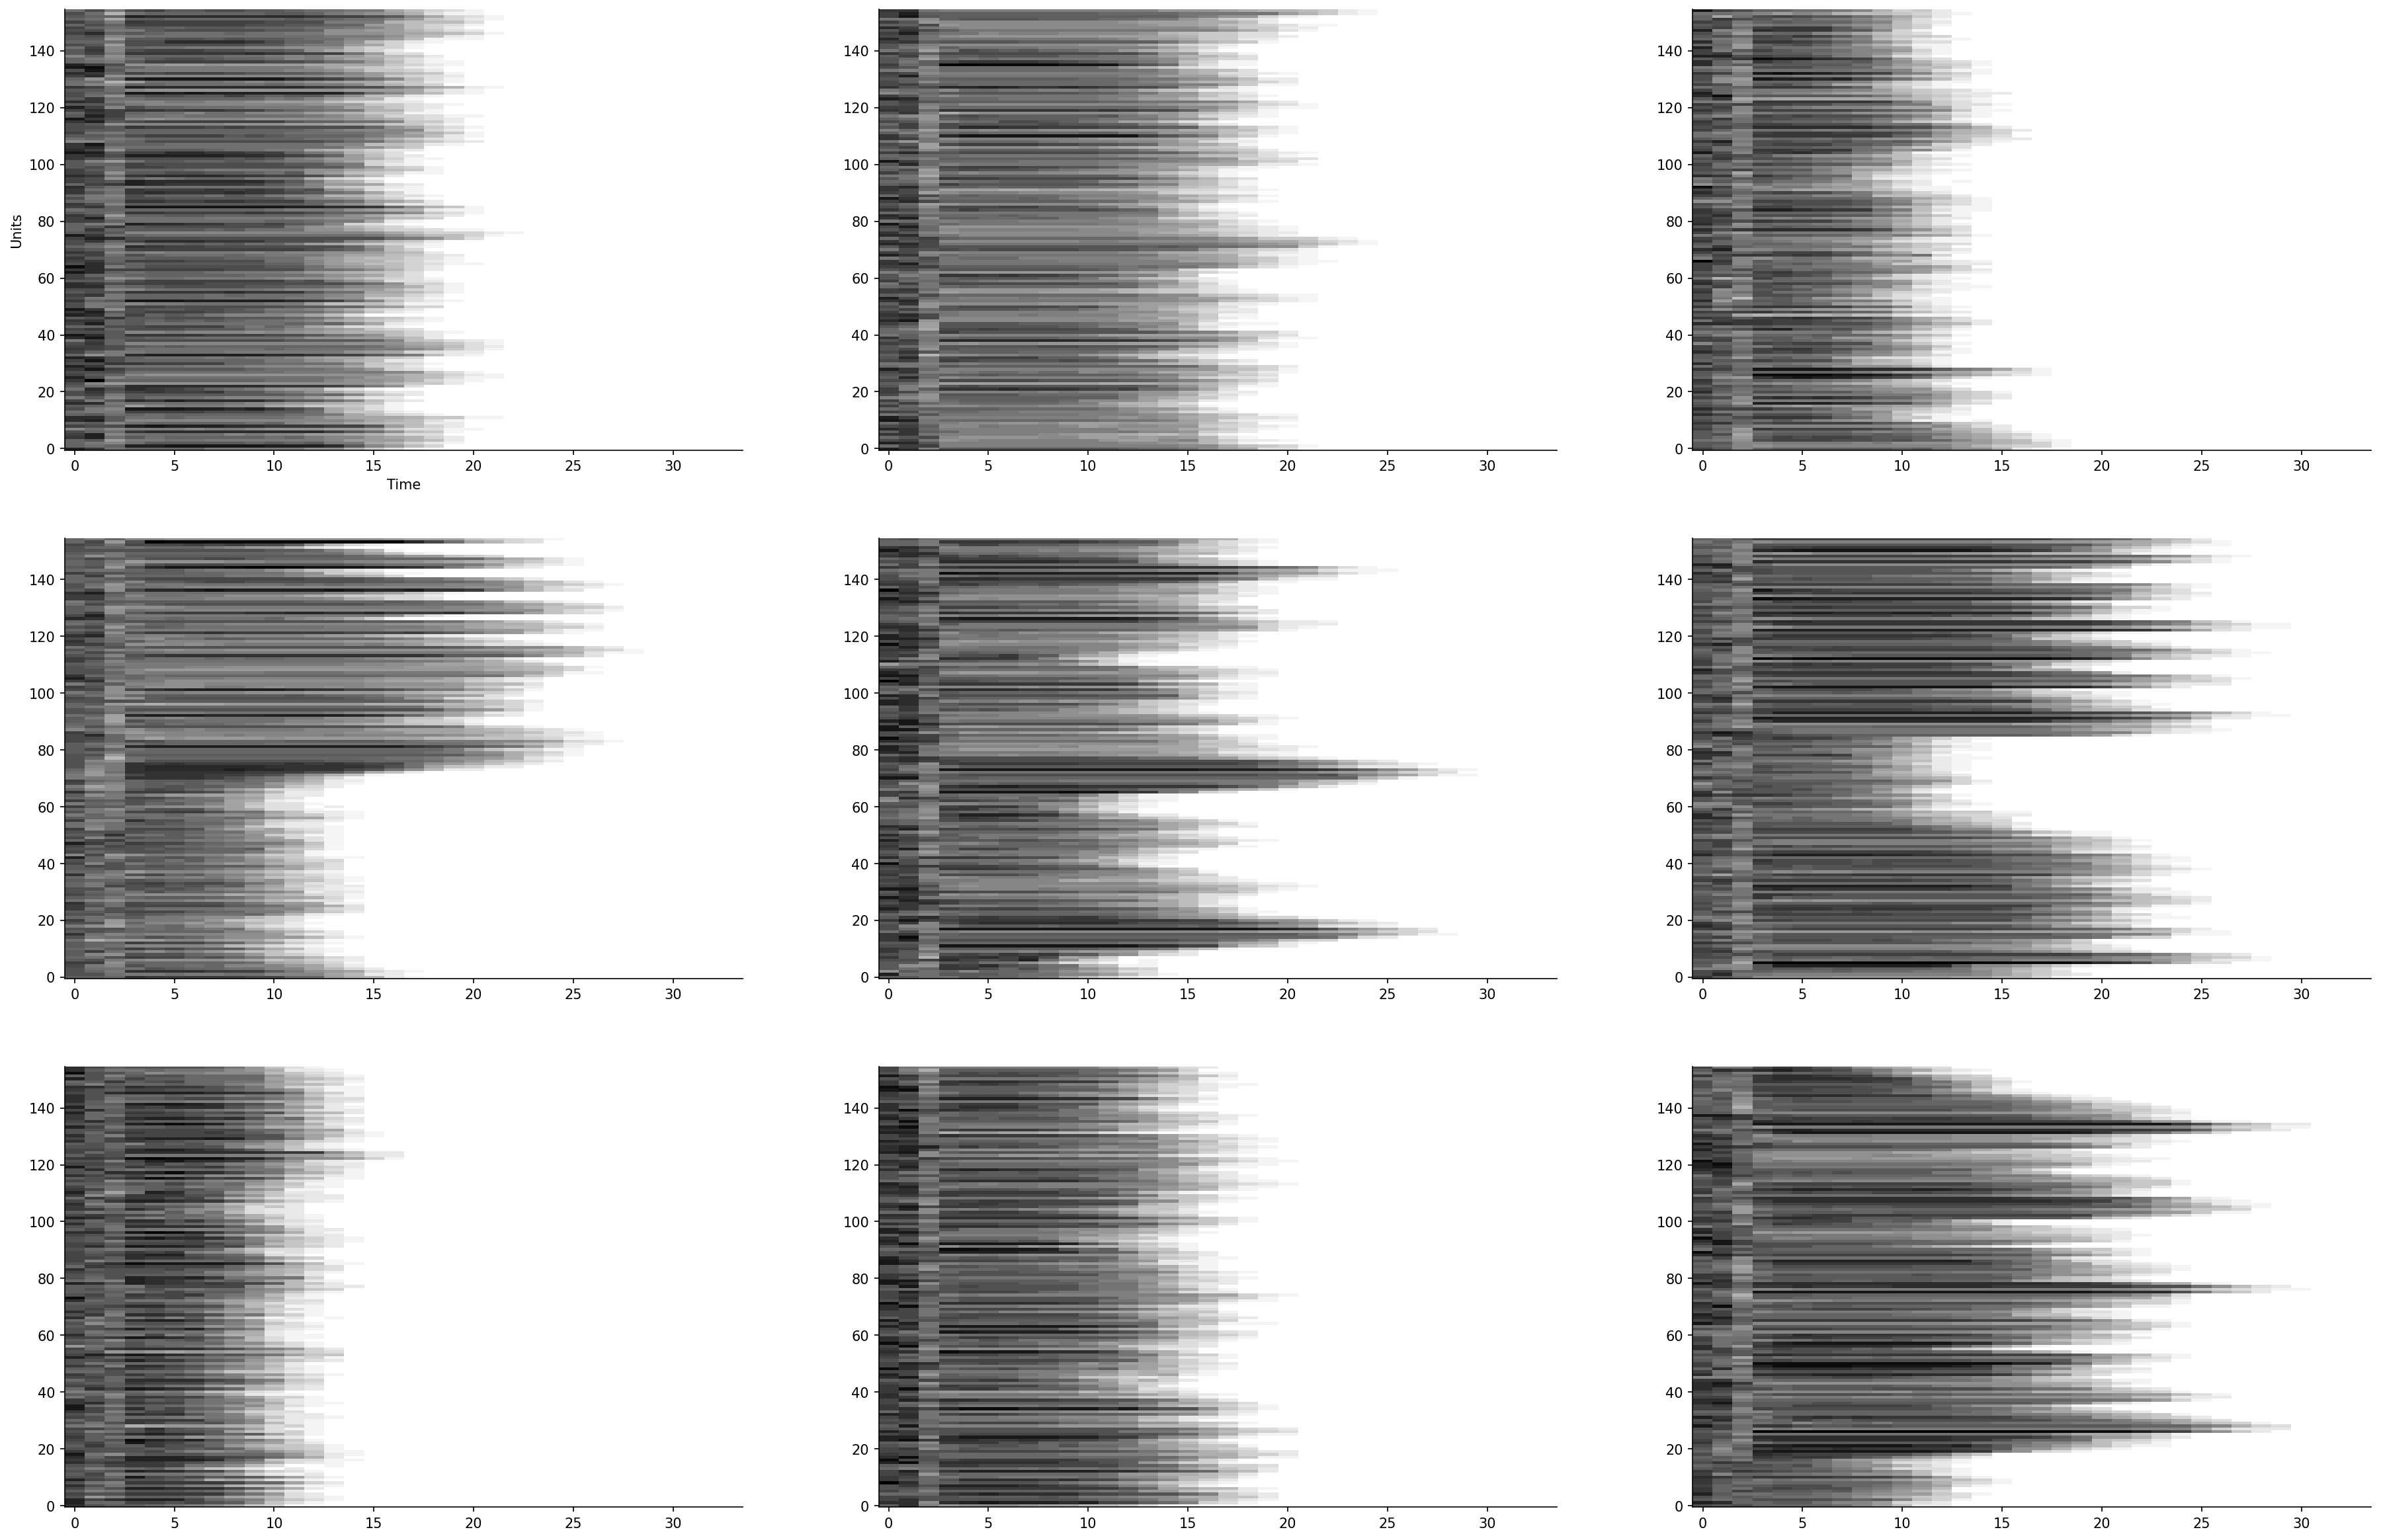

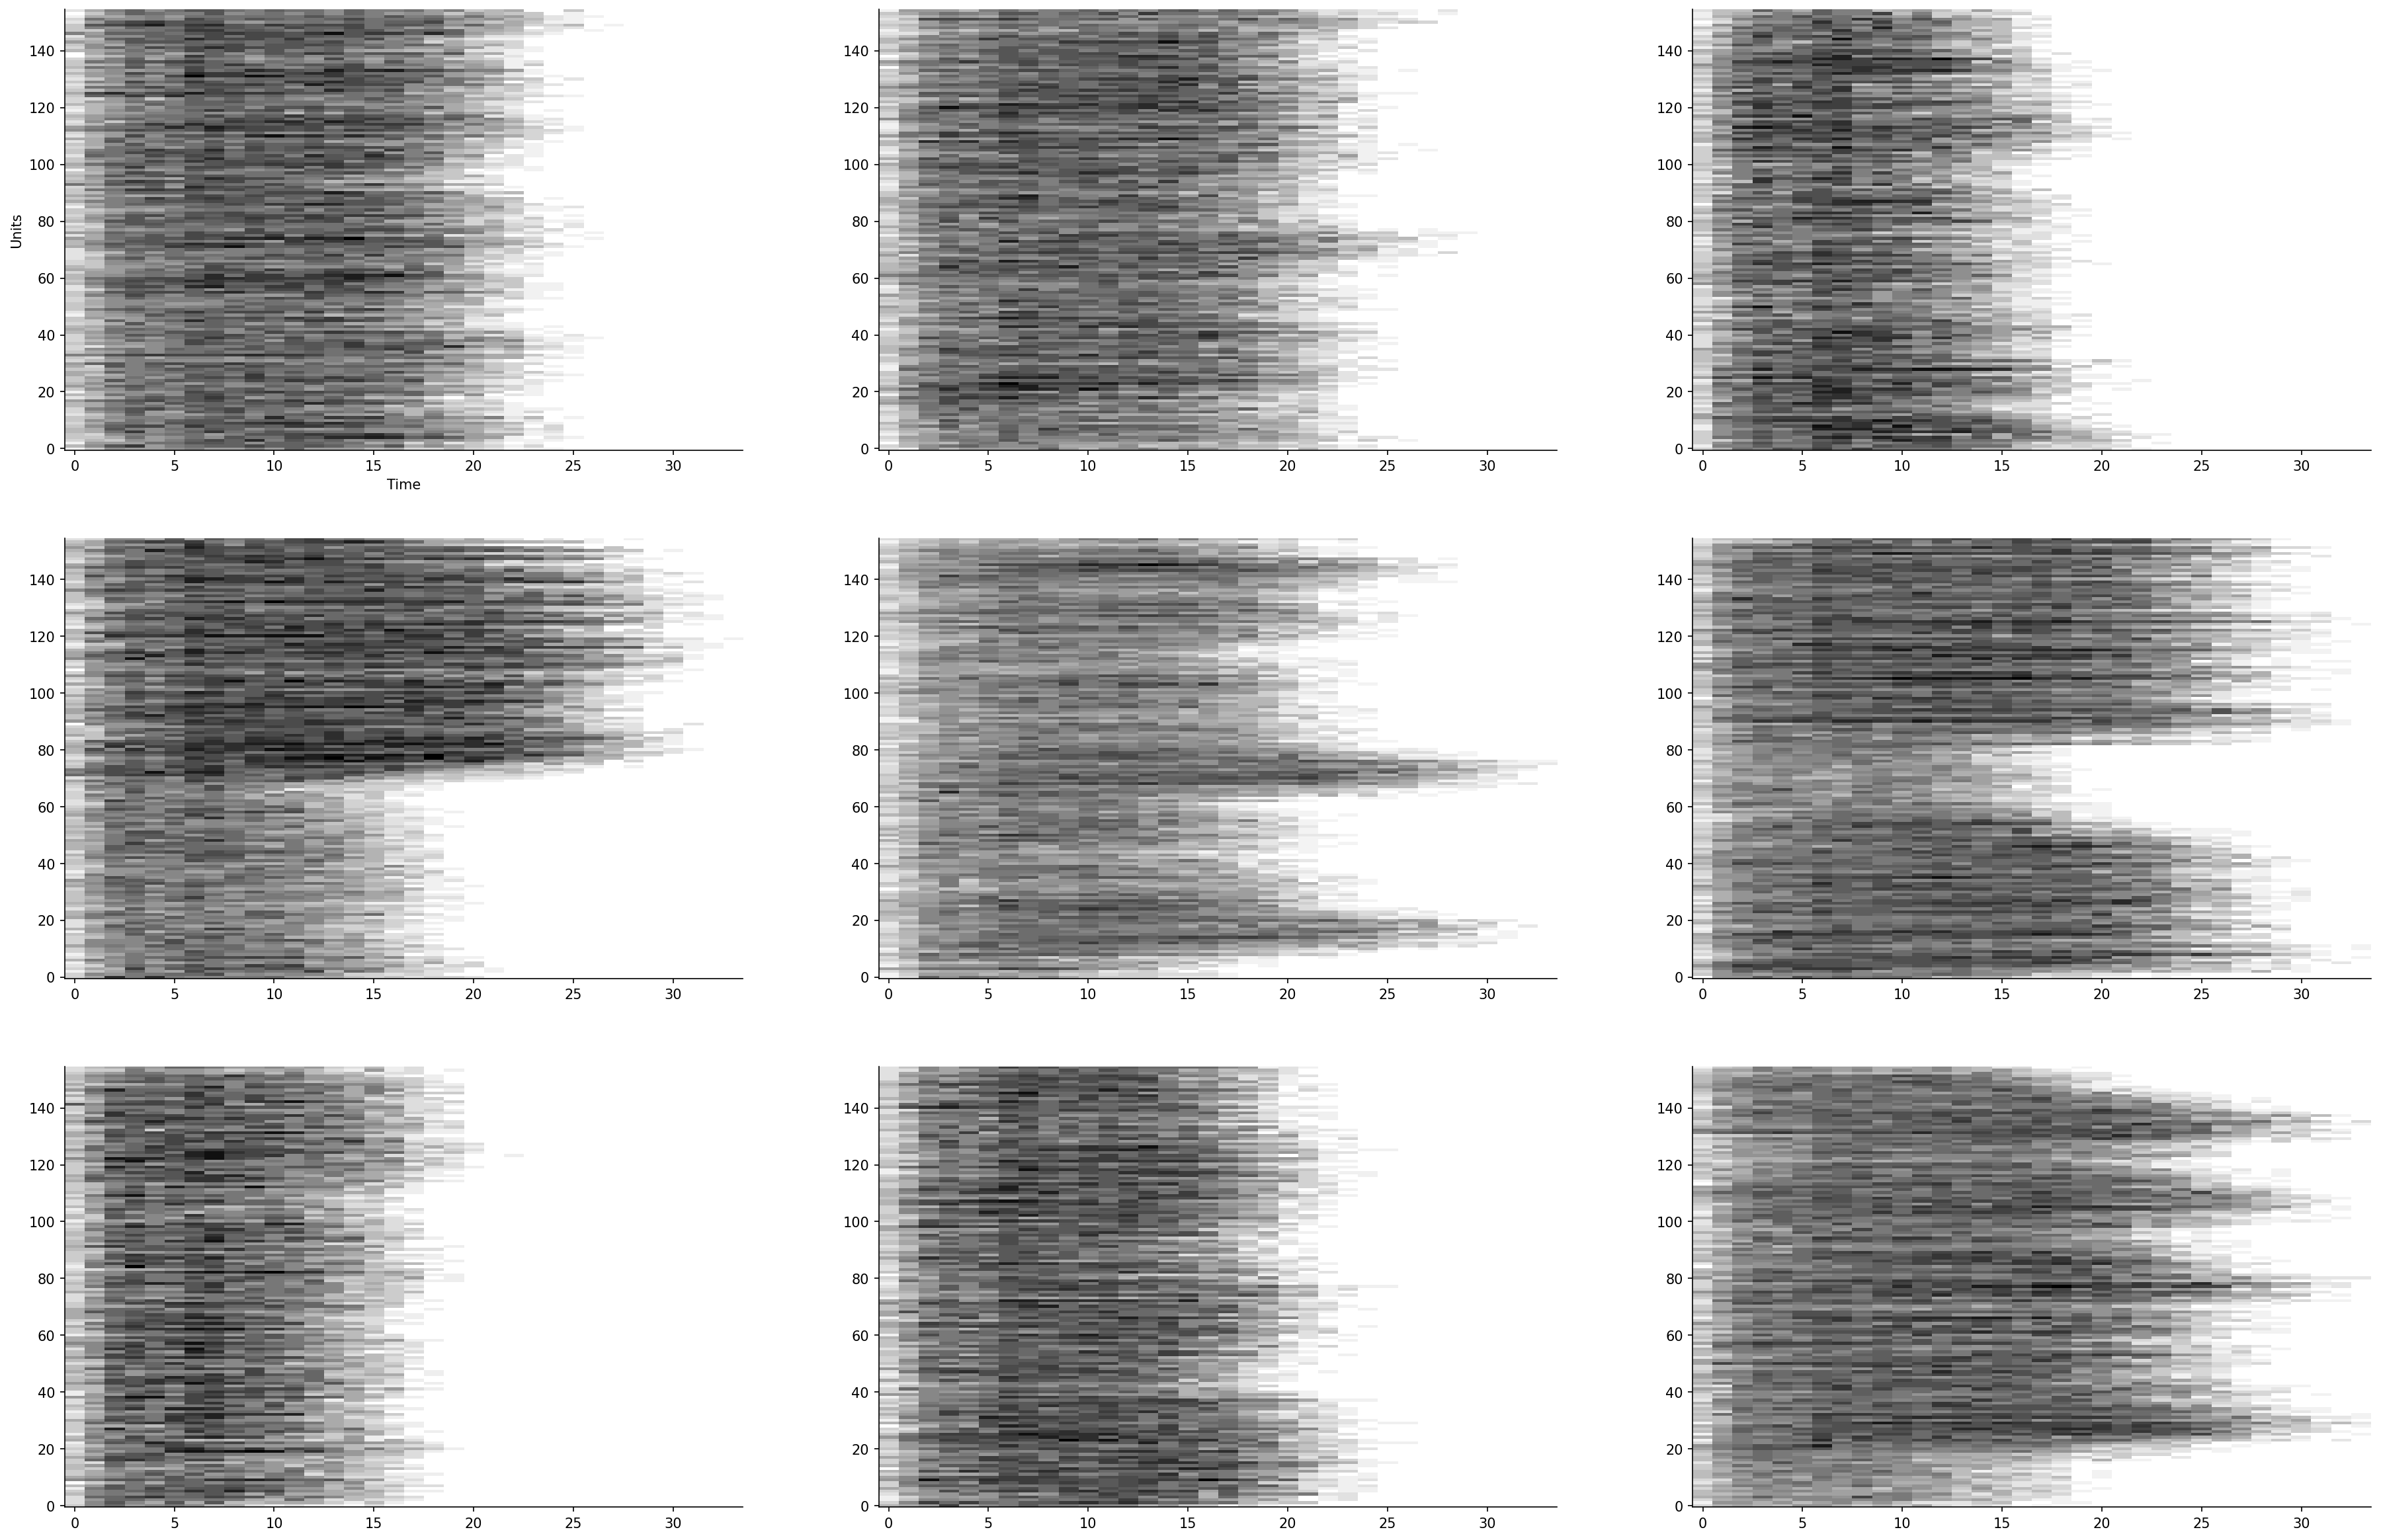

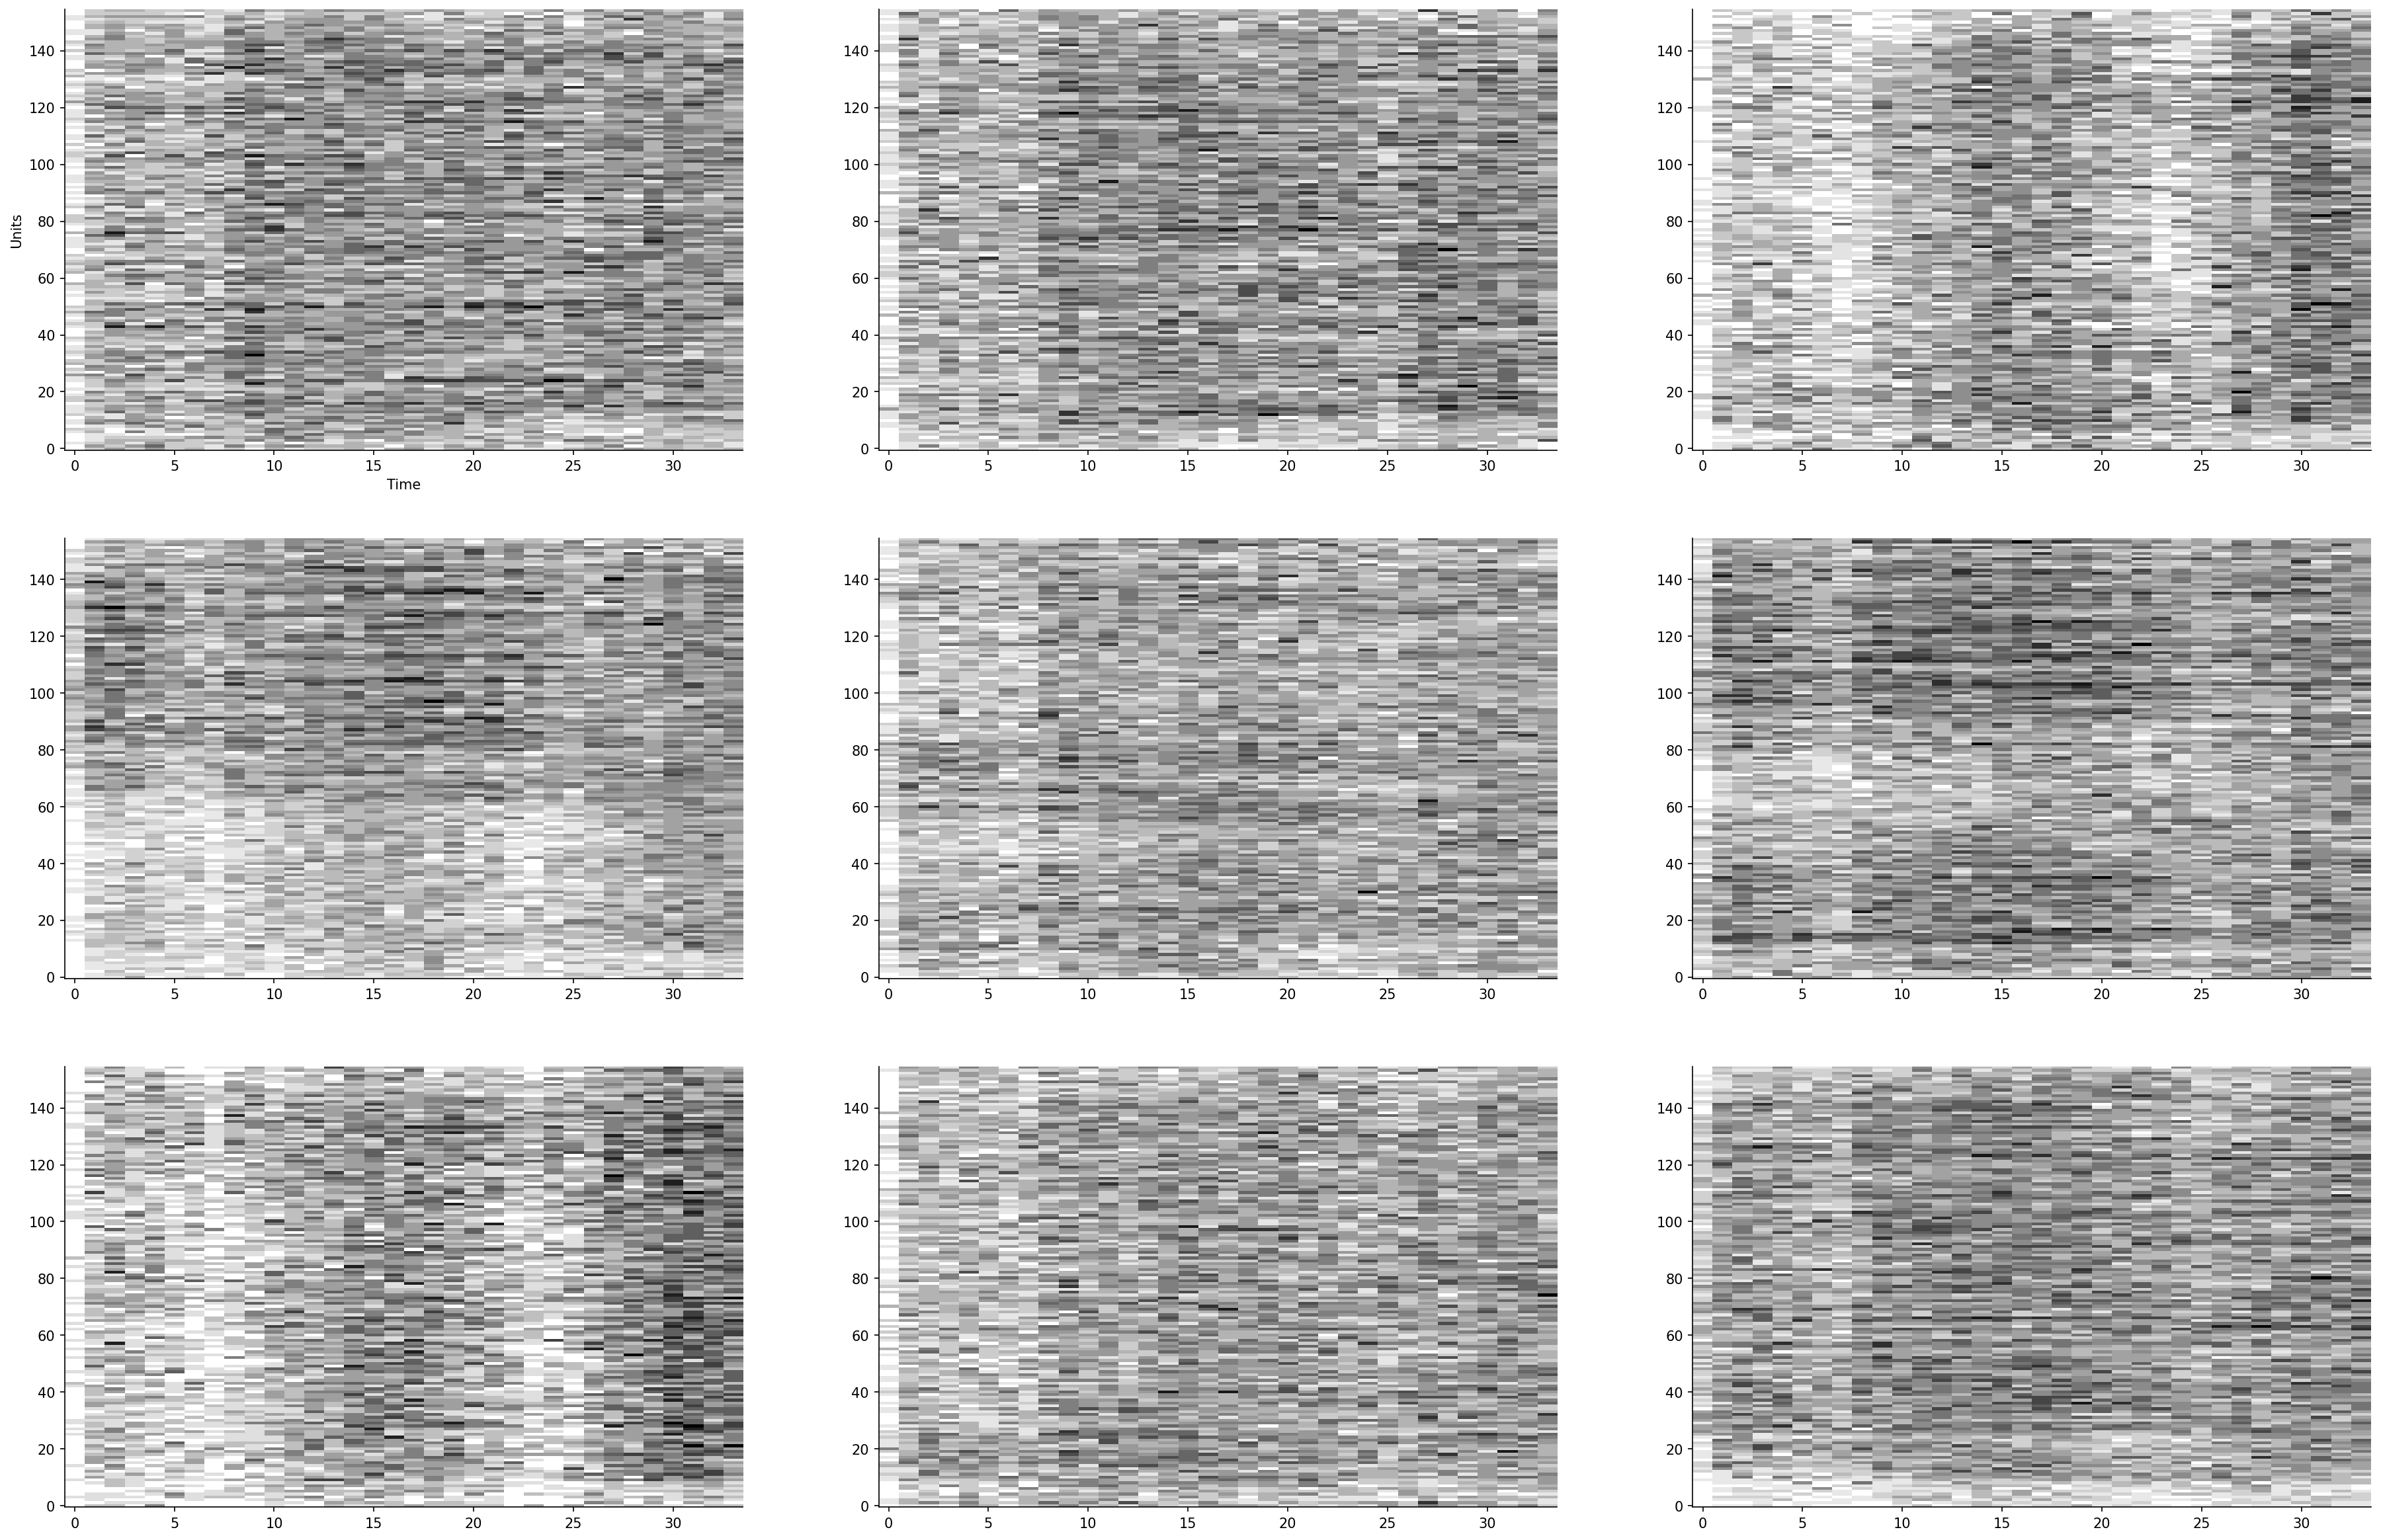

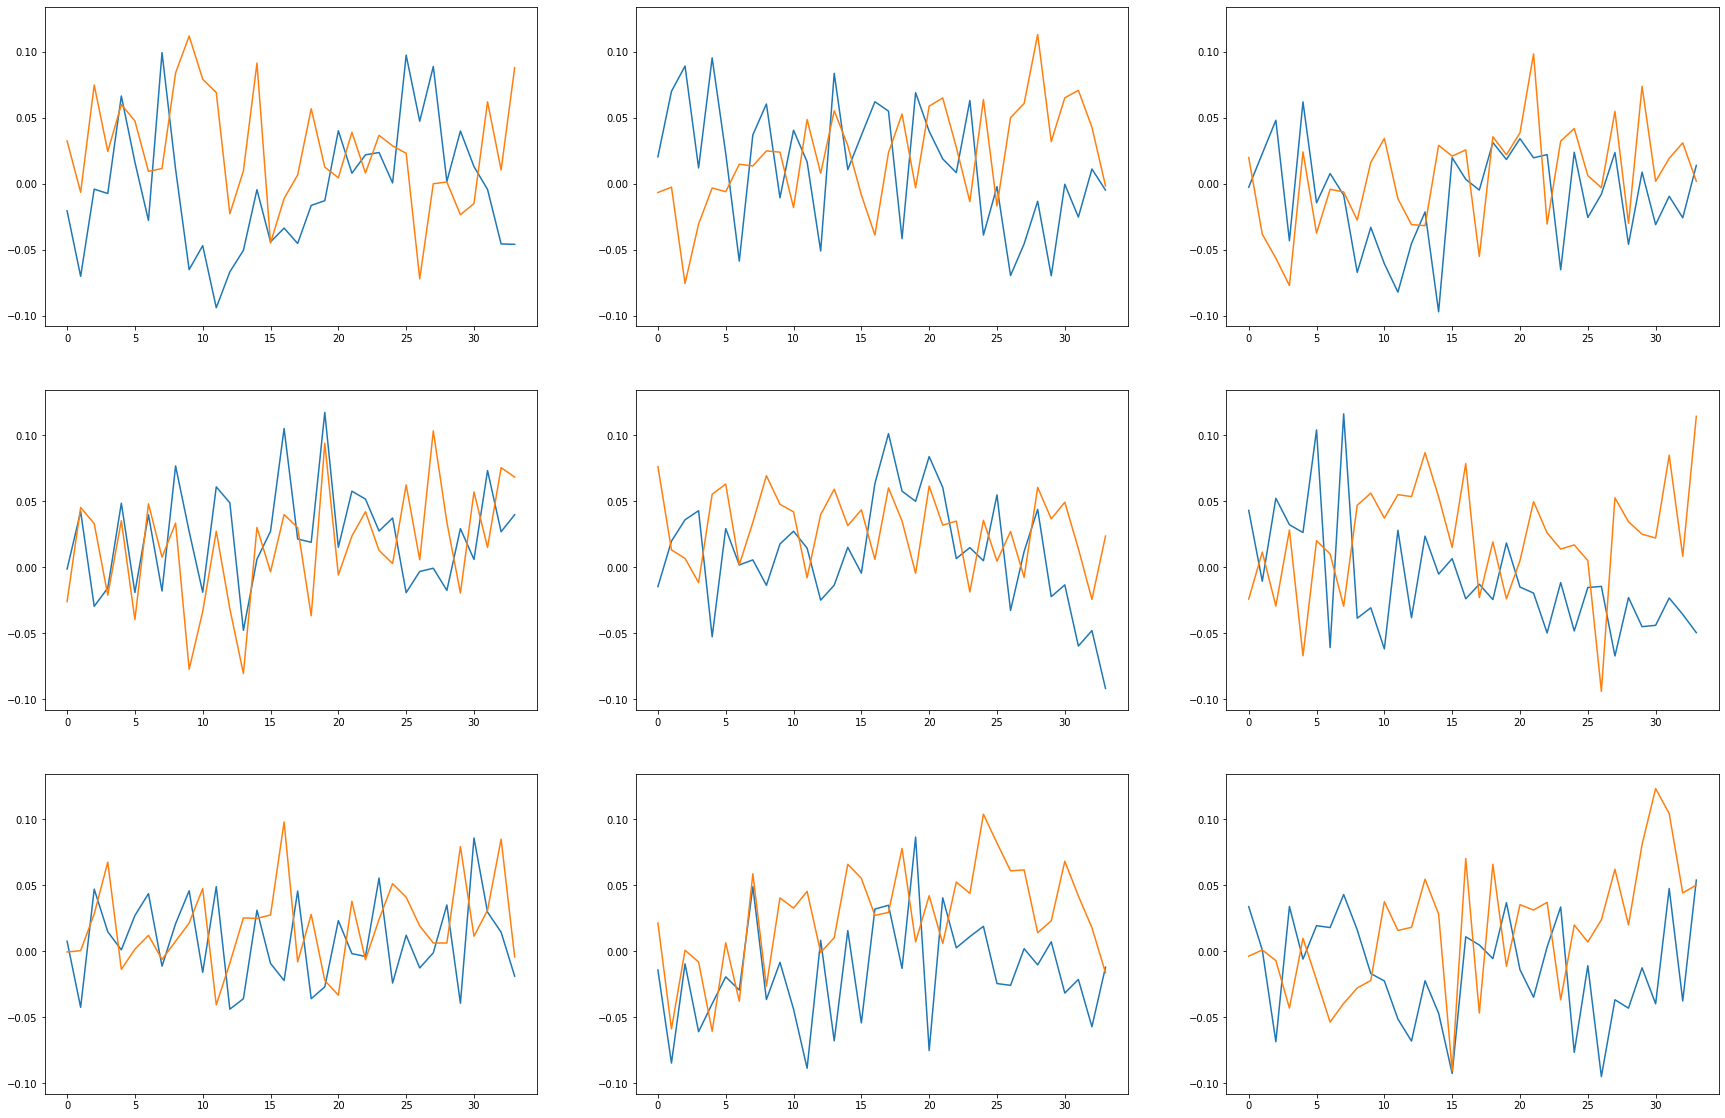

In [19]:
nb_plt = 9
batch_size = 70

batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConvLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [20]:
Y_train_batch = torch.tensor(Y_train_batch, dtype=torch.long, device=device)   
Y_Test_batch = torch.tensor(Y_Test_batch, dtype=torch.long, device=device)

/tmp/ipykernel_3777297/440090667.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_batch = torch.tensor(Y_train_batch, dtype=torch.long, device=device)
/tmp/ipykernel_3777297/440090667.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_Test_batch = torch.tensor(Y_Test_batch, dtype=torch.long, device=device)


In [21]:
def train(model, params, optimizer, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
    
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= len(X_train_batch)*warmup_epochs
        warmup_itr = 1
    
    hist = {'loss':[], 'valid_accuracy':[]}
    for e in range(nb_epochs):
        local_loss = []
        reg_loss = [[] for _ in range(len(model.layers)-1)]
        

           
        x_batch = X_train_batch.cuda()
        y_batch = Y_train_batch.cuda()
                
        output, loss_seq = model(x_batch)
        log_p_y = log_softmax_fn(output)
        loss_val = loss_fn(log_p_y, y_batch)
        local_loss.append(loss_val.item())
                
        for i,loss in enumerate(loss_seq[:-1]):
            reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
            loss_val += reg_loss_val
            reg_loss[i].append(reg_loss_val.item())
                    

        optimizer.zero_grad()
        loss_val.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 5)
        optimizer.step()
        model.clamp()
                
        if e < warmup_epochs:
            for g in optimizer.param_groups:
                g['lr'] *= (warmup_itr+1)/(warmup_itr)
            warmup_itr += 1
                
        
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        for i,loss in enumerate(reg_loss):
            mean_reg_loss = np.mean(loss)
            print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(snn.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        
        valid_accuracy = compute_classification_accuracy(model)
        hist['valid_accuracy'].append(valid_accuracy)
        print("Validation accuracy=%.3f"%(valid_accuracy))
        
    return hist
        
def compute_classification_accuracy(model):
    accs = []
    
    with torch.no_grad():
          
        x_batch = X_Valid_batch.cuda()
        y_batch = Y_Valid_batch.cuda()
        output, _ = model(x_batch)
        _,am=torch.max(output,1) # argmax over output units
        tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
       
    return np.mean(accs)

In [22]:
lr = 1e-3
weight_decay = 1e-5
reg_loss_coef = 0.1
nb_epochs = 20

params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(snn.layers)]
params += [{'params':l.b, 'lr':lr} for i,l in enumerate(snn.layers)]
if snn.layers[-1].time_reduction == "mean":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers[:-1])]
elif snn.layers[-1].time_reduction == "max":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers)]
else:
    raise ValueError("Readout time recution should be 'max' or 'mean'")
    
optimizer = RAdam(params)
 
gamma = 0.85
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

hist = train(snn, params, optimizer, reg_loss_coef, nb_epochs=nb_epochs,
                  scheduler=scheduler, warmup_epochs=1)

/data/valencia/optim.py:45: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Epoch 1: loss=1.26921
Layer 0: reg loss=0.00313
Layer 1: reg loss=0.00546
Layer 2: reg loss=0.00502
Layer 0: average number of spikes=0.1878
Layer 1: average number of spikes=0.1637
Layer 2: average number of spikes=0.1005
Validation accuracy=0.370
Epoch 2: loss=1.11921
Layer 0: reg loss=0.00313
Layer 1: reg loss=0.00546
Layer 2: reg loss=0.00502
Layer 0: average number of spikes=0.1878
Layer 1: average number of spikes=0.1637
Layer 2: average number of spikes=0.1005
Validation accuracy=0.478
Epoch 3: loss=0.89750
Layer 0: reg loss=0.00313
Layer 1: reg loss=0.00546
Layer 2: reg loss=0.00502
Layer 0: average number of spikes=0.1878
Layer 1: average number of spikes=0.1637
Layer 2: average number of spikes=0.1004
Validation accuracy=0.543
Epoch 4: loss=0.79294
Layer 0: reg loss=0.00313
Layer 1: reg loss=0.00546
Layer 2: reg loss=0.00502
Layer 0: average number of spikes=0.1878
Layer 1: average number of spikes=0.1637
Layer 2: average number of spikes=0.1004
Validation accuracy=0.630
Epoc

In [23]:
def compute_test_accuracy(model):
    accs = []
    
    with torch.no_grad():
          
        x_batch = X_Test_batch.cuda()
        y_batch = Y_Test_batch.cuda()
        output, _ = model(x_batch)
        _,am=torch.max(output,1) # argmax over output units
        tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
       
    return np.mean(accs)

test_accuracy = compute_test_accuracy(snn)
print("Test accuracy=%.3f"%(test_accuracy))

Test accuracy=0.711


In [24]:
x_batch = X_Test_batch.cuda()
y_batch = Y_Test_batch.cuda()
output, _ = snn(x_batch)
_,am=torch.max(output,1) # argmax over output units
Targets=y_batch.cpu().numpy()
Predictions=am.cpu().numpy()

In [25]:
from sklearn.metrics import confusion_matrix 
import itertools

In [26]:
cm = confusion_matrix(Targets, Predictions)

In [27]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('Actual Diagnosis')
    plt.xlabel('SNN Prediction')

Confusion matrix, without normalization
[[29  1]
 [12  3]]


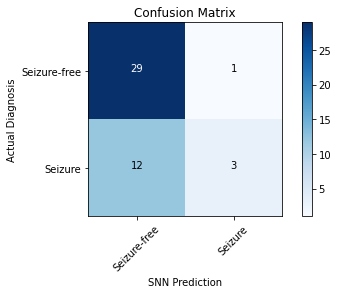

In [28]:
cm_plot_labels = ['Seizure-free', 'Seizure']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [29]:
from sklearn.metrics import classification_report
print (classification_report(y_batch.cpu().numpy(), am.cpu().numpy()))
#print (classification_report(y_batch, am))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82        30
           1       0.75      0.20      0.32        15

    accuracy                           0.71        45
   macro avg       0.73      0.58      0.57        45
weighted avg       0.72      0.71      0.65        45

